<a href="https://colab.research.google.com/github/dharshinidurai1816/Predictive_Maintenance/blob/main/Predictive_Maintenance_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

# For reproducibility
np.random.seed(42)

# Number of equipment records
n = 500

# Equipment types used in industry
equipment_types = ['Drill', 'Pump', 'Motor']

# Simulating sensor and operational data
df = pd.DataFrame({
    'id': np.arange(1, n + 1),
    'Equipment_Type': np.random.choice(equipment_types, size=n),
    'Noise_Level': np.random.normal(loc=70, scale=10, size=n).astype(int),  # dB levels
    'Operating_Hours': np.random.randint(100, 5000, size=n),                # Usage time
    'Load_Capacity': np.random.randint(100, 200, size=n),                   # in kg or similar
    'Engine_Temperature': np.random.normal(loc=90, scale=15, size=n).astype(int),  # °C
    'Oil_Level': np.random.randint(30, 80, size=n),                         # %
    'Vibrations': np.random.randint(1, 10, size=n),                         # severity scale
    'Health_Percentage': np.random.randint(40, 100, size=n),               # overall equipment health
    'Registration_Date': pd.date_range(start='2023-01-01', periods=n, freq='D')
})

# 🎯 Smart target based on real-world rule: maintenance needed when...
df['Maintenance_Required'] = (
    (df['Engine_Temperature'] > 100) &      # High temperature
    (df['Vibrations'] > 6) &                # Severe vibration
    (df['Health_Percentage'] < 65)          # Low health
).astype(int)

# Export CSV to use in Colab or Django
df.to_csv("smart_equipment_data_500.csv", index=False)

# Quick class balance check
print("Class distribution:\n", df['Maintenance_Required'].value_counts())


Class distribution:
 Maintenance_Required
0    484
1     16
Name: count, dtype: int64


In [ ]:
# STEP 1: Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# STEP 2: Load the synthetic dataset (created earlier)
df = pd.read_csv("smart_equipment_data_500.csv")

In [ ]:
# STEP 3: Encode categorical variable (Equipment_Type)
le = LabelEncoder()
df['Equipment_Type'] = le.fit_transform(df['Equipment_Type'])
reverse_map = dict(zip(le.transform(le.classes_), le.classes_))

# STEP 4: Feature/target separation
X = df.drop(['Maintenance_Required', 'Registration_Date'], axis=1)
y = df['Maintenance_Required']

# STEP 5: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
# STEP 6: Train RandomForest Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# STEP 7: Model Evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy: {accuracy:.2%}")
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))

✅ Accuracy: 98.67%

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       145
           1       1.00      0.60      0.75         5

    accuracy                           0.99       150
   macro avg       0.99      0.80      0.87       150
weighted avg       0.99      0.99      0.99       150



In [ ]:
probs = model.predict_proba(X_test)[:, 1]  # Probability of class 1

# STEP 9: Maintenance Alert Thresholds
thresholds = {
    'Low': 0.15,
    'Medium': 0.82,
    'High': 0.9,
    'Critical': 0.95
}

# STEP 10: Generate Alerts based on probabilities
alerts = pd.DataFrame(index=X_test.index)
for level, threshold in thresholds.items():
    alerts[level + '_Alert'] = probs > threshold

In [ ]:

# STEP 11: Map Alert Levels
result_df = pd.DataFrame()
result_df['Maintenance_Alerts'] = alerts.sum(axis=1)
result_df['Maintenance_Level'] = pd.cut(
    result_df['Maintenance_Alerts'],
    bins=[-1, 0, 1, 2, 3, float('inf')],
    labels=['No Alert', 'Low', 'Medium', 'High', 'Critical'],
    right=True
)
result_df['Critical_Alerts'] = result_df['Maintenance_Level'] == 'Critical'

In [ ]:

# STEP 12: Combine results with input features
X_test['Equipment_Type'] = X_test['Equipment_Type'].map(reverse_map)
final_report = pd.concat([result_df, X_test.reset_index(drop=True)], axis=1)

# STEP 13: Save Report
final_report.to_csv("Final_Predictive_Report.csv", index=False)
print("\n📄 Final_Predictive_Report.csv saved successfully.")



📄 Final_Predictive_Report.csv saved successfully.


/tmp/ipython-input-9-1815299326.py:12: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


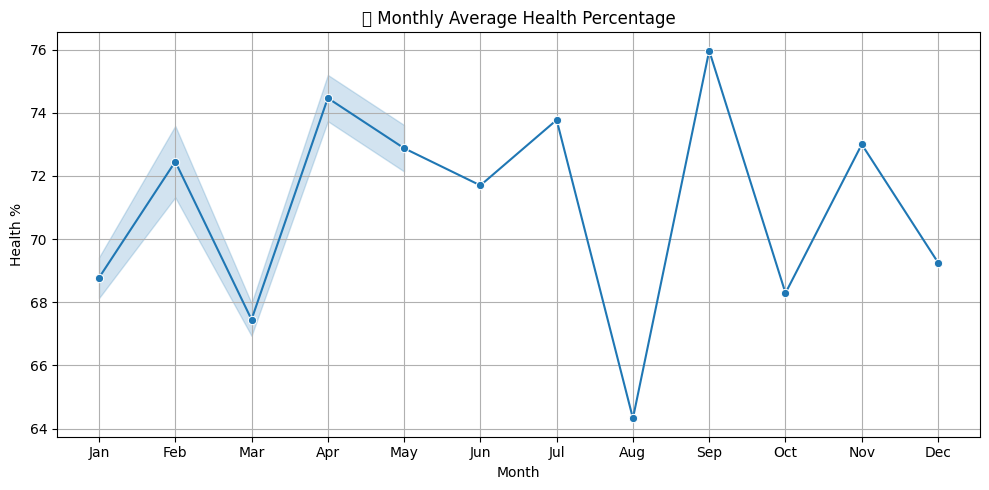

In [ ]:
# STEP 14: Health Trend Graph (Monthly Avg Health %)
df['month'] = pd.to_datetime(df['Registration_Date']).dt.to_period("M")
monthly_health = df.groupby('month')['Health_Percentage'].mean().reset_index()
monthly_health['month'] = monthly_health['month'].dt.strftime('%b')

plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_health, x='month', y='Health_Percentage', marker='o')
plt.title("📊 Monthly Average Health Percentage")
plt.ylabel("Health %")
plt.xlabel("Month")
plt.grid(True)
plt.tight_layout()
plt.show()